In [1]:
#import
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'figure.figsize':(15, 6)})

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#load data
#factor
factors = pd.read_excel(r'dfa_analysis_data.xlsx',sheet_name = 'factors')
factors = factors.set_index('Date')
factors = factors.drop(['RF'], axis=1)
factors.head()

,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013
1926-10-31,-0.0324,-0.0009,0.0070
1926-11-30,0.0253,-0.0010,-0.0051


In [3]:
#portfolio
port_ret = pd.read_excel(r'dfa_analysis_data.xlsx',sheet_name = 'portfolios (total returns)')
port_ret = port_ret.set_index('Date')

rf = pd.read_excel(r'dfa_analysis_data.xlsx',sheet_name = 'factors')
rf = rf.set_index('Date')
rf = rf['RF'].to_frame()
port_ret = port_ret.merge(rf['RF'], on = rf.index).fillna(0).rename(columns={'key_0' : 'Date'})
port_ret.index = port_ret['Date']
port_ret = port_ret.drop(['Date'], axis=1)
for col in port_ret.columns:
    port_ret[col] = port_ret[col] - port_ret['RF']


port_ret = port_ret.drop(['RF'], axis=1)
port_ret.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056048,-0.019206,0.002675,-0.016780,0.018334,0.009877,0.021992,0.002726,-0.028249,-0.005544,...,0.013693,0.013078,0.010778,0.000527,0.022478,0.032339,0.058702,0.018066,0.028911,0.003423
1926-08-31,-0.022706,-0.082782,0.011296,0.012106,0.081468,0.021118,-0.014349,0.037584,0.002538,0.059175,...,0.010836,0.036230,0.017521,0.019206,0.050922,0.007624,0.039403,0.017631,0.052349,0.075076
1926-09-30,-0.050591,-0.028454,-0.045717,-0.035029,0.006349,-0.028840,-0.014918,0.008529,-0.037780,-0.011701,...,0.008623,-0.007550,-0.019936,0.012346,0.006430,-0.015206,0.034238,-0.001350,-0.009787,-0.026584
1926-10-31,-0.096929,-0.038719,-0.038148,0.031213,-0.028676,-0.031269,-0.035863,-0.053945,-0.083391,-0.016413,...,-0.036561,-0.029759,-0.024270,-0.034251,-0.056725,-0.030613,-0.033271,-0.025637,-0.049919,-0.061329
1926-11-30,0.052788,0.038777,0.021523,-0.047594,0.002262,0.027933,-0.026790,0.026978,0.048446,0.024192,...,0.031348,0.020787,0.034235,0.046220,0.015113,0.039846,0.022226,0.012104,0.033519,0.022536


## 2 The Factor

### 2.1 Calculate their univariate performance statistics:
- ### mean
- ### volatility
- ### Sharpe
- ### VaR(.05)

In [5]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [6]:
factor_summary = performance_summary(factors)
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.081421,0.185140,0.439779,-0.08022
SMB,0.022779,0.109802,0.207459,-0.04206
HML,0.041191,0.123780,0.332780,-0.04210


### Report these for the following three subsamples:
- ### Beginning - 1980
- ### 1981 - 2001
- ### 2002 - End

In [10]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2023 = factors.loc['2002':]

In [11]:
#beginning to 1980
sub_1980_summary = performance_summary(sub_1980)
sub_1980_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.081138,0.205050,0.395696,-0.083985
SMB,0.033985,0.114568,0.296638,-0.043400
HML,0.049479,0.133825,0.369727,-0.042910


In [12]:
#1981 to 2001
sub_2001_summary = performance_summary(sub_2001)
sub_2001_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.077257,0.157396,0.490847,-0.064545
SMB,-0.000862,0.118346,-0.007283,-0.046515
HML,0.063776,0.111183,0.573612,-0.041790


In [13]:
#2002 to end
sub_2023_summary = performance_summary(sub_2023)
sub_2023_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.086187,0.155313,0.554923,-0.07913
SMB,0.017486,0.086443,0.202280,-0.03823
HML,-0.001710,0.107517,-0.015901,-0.04174


### 2.2) Based on the factor statistics above, answer the following.

a) No, given that SMB has negative mean excess return in 1981-2001 and HML has negative mean excess return in 2002 to 2023, we see not every factor has a premium in each subsample.

b) Yes, the premium to the size factor declined after 1980 and recovered during the 2002-2023 subsample.

c) No, the premium to the value factor increases during 1990 in comparison to 1926-1980.

d) The market factor performs consistently throughout all three periods. The size factor increases the premium in this latest period, whereas the premium to the value factor turned to negative in this period.

### 2.3) The factors are constructed in such a way as to reduce correlation between them. 

### Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? 

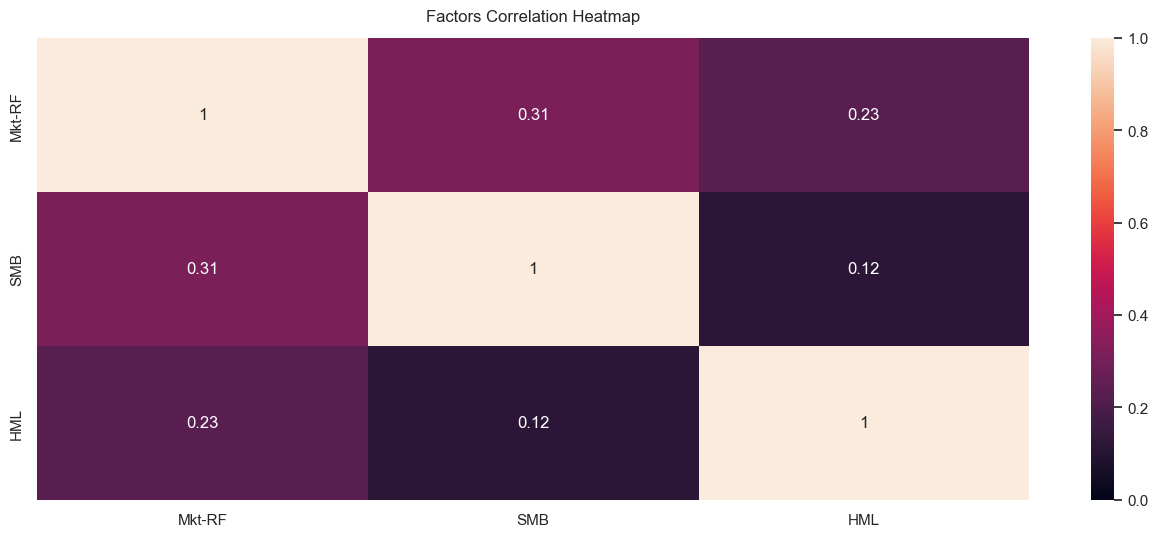

In [19]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

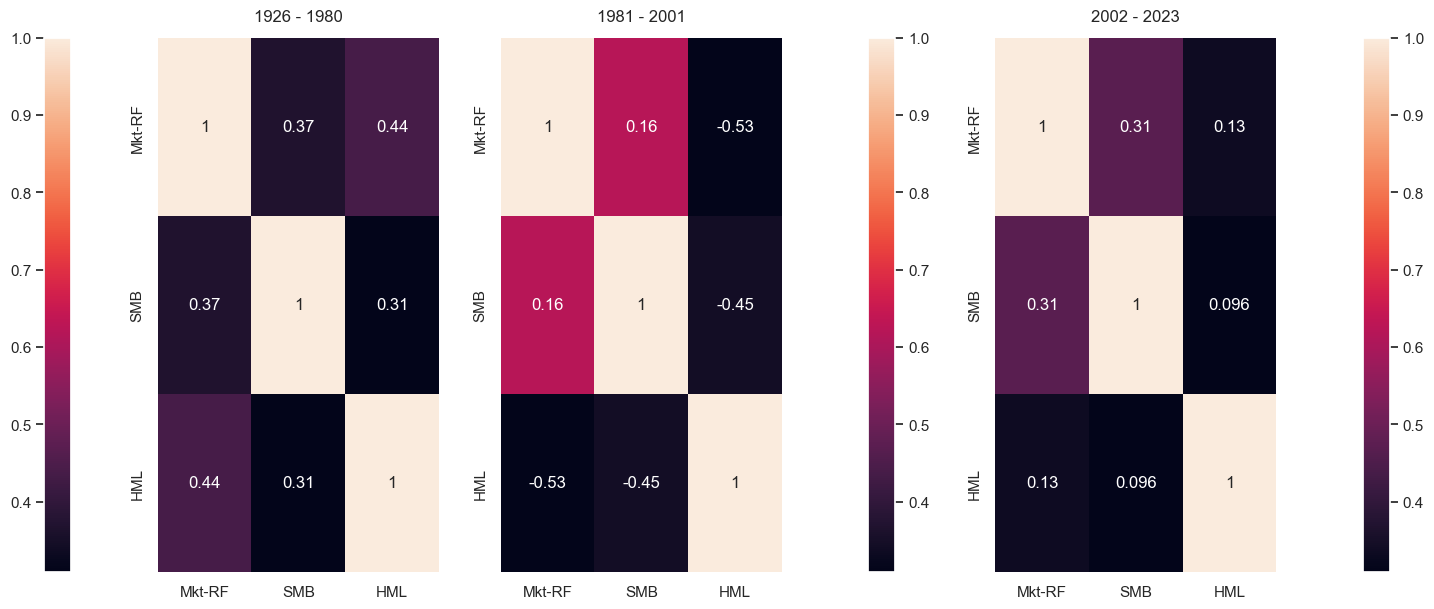

In [23]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2023.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2023', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

In general, the correlation across three assets classes are small with correlations lower than 0.31 in the whole sample. Looking at the subsamples, we see the correlation are mainly enlarged by the 1926-1980 period, and the correlation in the rest of the two periods are relatively small.

### 2.4) Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

In [ ]:
#cumulative returns

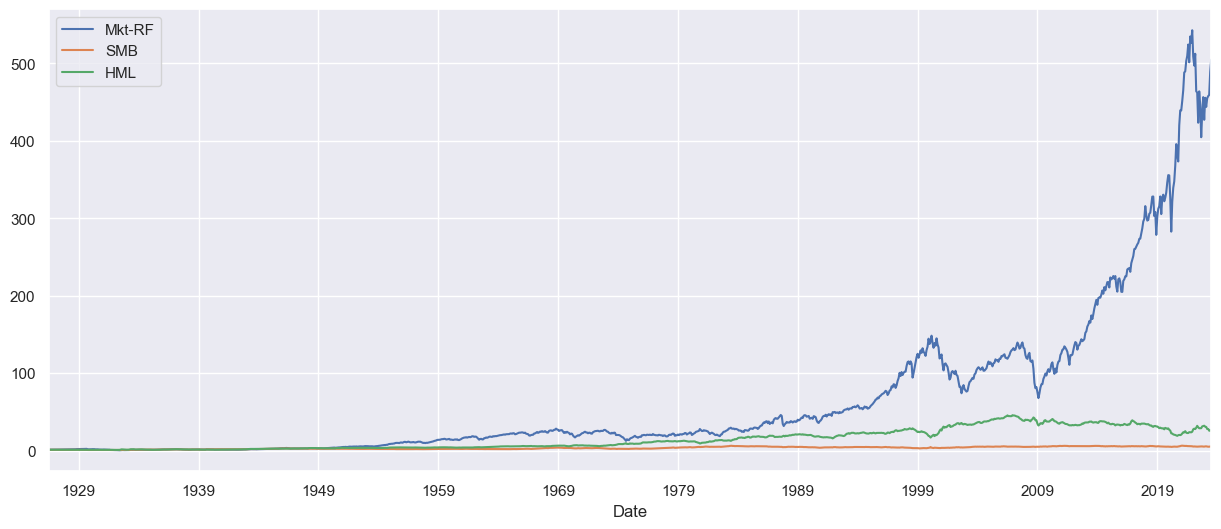

<Figure size 10000x600 with 0 Axes>

In [22]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(100, 6))
plt.show()

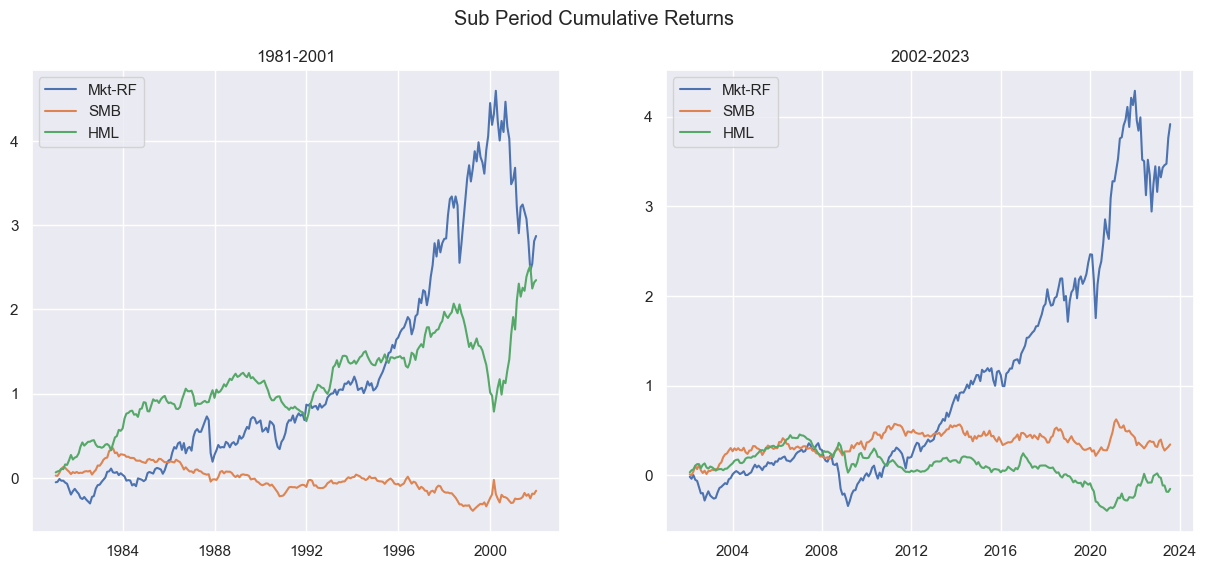

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2023 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2023.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2023')

### 2.5）Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

It appears that market factor and the value factor were valuable in 1981 to 2001, while the size factor moved around zero return in this period. When it comes to post 2001, all three factors hover at zero due to the internet bubble, but the market factor were influenced the most. After the 2008 financial crisis, market factor has rising premium. Based on the graphs, I would advise DFA considering the rotation across factors while adding more factors to generate higher alpha.

## 3. CAPM

#### DFA believes that premia in stocks and stock portfolios is related to the three factors. Let's test 25 equity portfolios that span a wide range of size and value measures

- #### PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as $r^{i}$, for n = 1,....,25.
- #### Note that while the factors were given as excess returns, the portfolios are total returns.
- #### For this entire problem, focus on the 1981-Present subsample.

### 3.1) Summary Statistics.

### For each portfolio,

- ### Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- ### Calculate the (annualized) univariate statistics from 1.1.

In [25]:
port_summary = performance_summary(port_ret.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.008607,0.272612,0.031572,-0.121077
ME1 BM2,0.091784,0.235700,0.389411,-0.095709
ME1 BM3,0.092669,0.197915,0.468227,-0.085817
ME1 BM4,0.117387,0.192404,0.610105,-0.076442
SMALL HiBM,0.129434,0.208295,0.621397,-0.088647
ME2 BM1,0.059889,0.244792,0.244654,-0.103985
ME2 BM2,0.101862,0.204197,0.498842,-0.084928
ME2 BM3,0.107086,0.184794,0.579484,-0.079119
ME2 BM4,0.108899,0.180701,0.602648,-0.077423
ME2 BM5,0.116268,0.213841,0.543715,-0.096701


### can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

Text(0, 0.5, 'Mean Excess Returns')

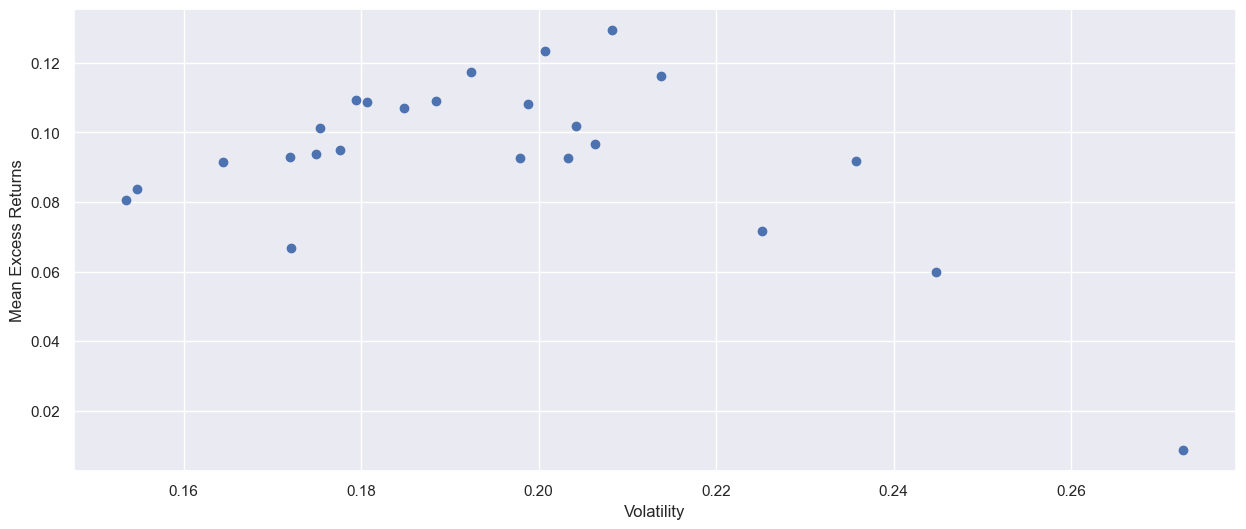

In [26]:
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns")


Text(0, 0.5, 'Mean Excess Returns')

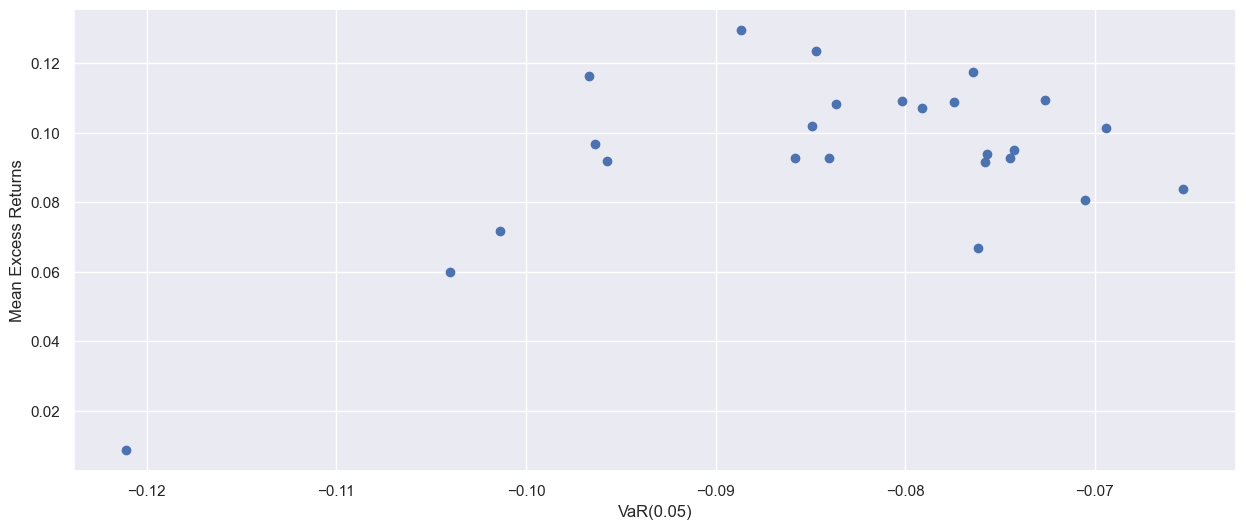

In [27]:
plt.scatter( port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns")

### based on the two scatterplots, there is no enough evidence to show how well the differences in volatility or VaR can explain the differences in mean excess return.

### 3.2 CAPM

#### The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)
#### Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{m}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{m}$.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}]$</center>
#### Let's examine whether that seems plausible.

### 3.2.a) For each of the n = 25 test portfolios, run the CAPM time-series regression: <br> 
###   <center> $\tilde{r}_{t}^{i}$ = $α^{i} + β^{i,m}\tilde{r}^{m}_{t} + ε_{t}$ </center>
### So you are running 25 separate regressions, each using the T-sized sample of time-series data.

In [28]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [29]:
portfolios = port_ret.columns
factor = factors['1981-01-01':]['Mkt-RF']

df_lst= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst.append(pd.DataFrame([[beta,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'],index = [port]))


### 3.2.b) report regression metrics

In [30]:
reg_performance = pd.concat(df_lst)
reg_performance

,Market Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.350120,-0.101808,0.598400,0.006375,-0.589319
ME1 BM2,1.160335,-0.003108,0.591270,0.079101,-0.020651
ME1 BM3,1.034045,0.008100,0.665975,0.089618,0.070829
ME1 BM4,0.967278,0.038280,0.616611,0.121358,0.321317
SMALL HiBM,0.988304,0.048612,0.549235,0.130966,0.347576
ME2 BM1,1.333429,-0.049164,0.723908,0.044914,-0.382220
ME2 BM2,1.128858,0.009540,0.745617,0.090235,0.092637
ME2 BM3,1.024793,0.023280,0.750294,0.104495,0.252046
ME2 BM4,0.970403,0.029532,0.703593,0.112220,0.300229
ME2 BM5,1.109383,0.025536,0.656627,0.104805,0.203817


### c) If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM were true, the Treynor ratios should be the same, the alpha should be zero, and the information ratios should also equals zero.

## 3.3) Cross-sectional Estimation

#### Let's test (CAPM) directly. We already have what we need:

- #### The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.
- #### The regressor, (x): the market beta from each of the n = 25 time-series regressions.

- #### Then we can estimate the following equation:

<center> $  \underbrace{\mathop{\mathbb{E}}[\tilde{r}^{i}]}_\text{n x 1 data} = 
    \underbrace{\eta}_\text{regression intercept} +
    \underbrace{\beta^{i,m}}_\text{n x 1 data} *\underbrace{\lambda_{m}}_\text{regression estimate} + \underbrace{\upsilon}_\text{n x 1 residuals}
 $ </center>
 
- #### Note that we use sample means as estimates of $\mathop{\mathbb{E}}[\tilde{r}^{i}]$.
- #### This is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- #### This is a single regression, where we are combining evidence across all n = 25 series. Thus, it is a cross-sectional regression!
- #### The notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

In [ ]:
# 3.3 a&b&c

In [31]:
fund_ret = port_ret.loc['1981-01-01':].mean()
factor = reg_performance['Market Beta']
reg = regression_based_performance(factor,fund_ret,0)
beta = reg[0][0]
treynor_ratio = reg[1]
information_ratio = reg[2]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg = pd.DataFrame([[beta,alpha/12,r_squared]],columns=['Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg

,Beta,Alpha,R-Squared
Cross-Sectional Estimation,-0.008656,0.016986,0.272833


### If CAPM were true, Beta for the cross-sectional estimation should be the mean returns on market, alpha should be zero, and R-Sqaured should be 100%.

### 3.3.4Broadly speaking, do these results support DFA’s belief in size and value portfolios containing premia unrelated to the CAPM?

Given the previous test on CAPM, Beta, Alpha, and R^2 deviated from the prediction of CAPM. Thus, it supports the belief that other factors such as size and value can also explain mean excess returns of the portfolio.

## 4. Extension

### 4.1) Re-do the analysis of 3.3 and 3.4, but instead of using the market return as the factor, use all three factors, (MKT, SMB, and HML). Note again that all three are already given as excess returns, so there is no need to use the risk-free rate data.
### Thus, instead of testing (CAPM), you will be testing the Fama-French 3-Factor Model.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,m} \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}] +  \beta^{i,s} \mathop{\mathbb{E}}[\tilde{r}^{s}_{t}] +  \beta^{i,v} \mathop{\mathbb{E}}[\tilde{r}^{v}_{t}]$</center>

In [32]:
portfolios = port_ret.columns
factor = factors.loc['1981':]

df_lst_ff= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,alpha,r_squared,treynor_ratio,information_ratio]],columns=['Market Beta','Size Beta','Value Beta','Alpha','R-Squared','Treynor Ratio','Information Ratio'],index = [port]))

reg_performance_ff = pd.concat(df_lst_ff)
reg_performance_ff


,Market Beta,Size Beta,Value Beta,Alpha,R-Squared,Treynor Ratio,Information Ratio
SMALL LoBM,1.109864,1.382822,-0.257933,-0.085944,0.889121,0.007755,-0.946733
ME1 BM2,0.964265,1.316603,-0.015634,0.002292,0.909553,0.095185,0.032343
ME1 BM3,0.917788,1.048864,0.268570,0.000540,0.943533,0.100970,0.011601
ME1 BM4,0.878718,1.057622,0.472523,0.022152,0.938856,0.133589,0.465496
SMALL HiBM,0.930187,1.061953,0.691210,0.023256,0.872350,0.139149,0.312548
ME2 BM1,1.138805,1.016961,-0.315877,-0.032160,0.939757,0.052590,-0.535355
ME2 BM2,1.011494,0.905911,0.112696,0.008052,0.939132,0.100705,0.159761
ME2 BM3,0.974947,0.713799,0.388736,0.009444,0.920256,0.109837,0.180882
ME2 BM4,0.942648,0.740196,0.571512,0.008076,0.937406,0.115525,0.178753
ME2 BM5,1.091105,0.924225,0.828847,-0.006108,0.952419,0.106560,-0.131075


In [33]:
fund_ret = port_summary['Mean']
factor = reg_performance_ff.loc[:,['Market Beta','Size Beta','Value Beta']]
reg = regression_based_performance(factor,fund_ret,0)
beta_mkt = reg[0][0]
beta_size = reg[0][1]
beta_value = reg[0][2]
treynor_ratio = reg[1]
information_ratio = reg[2]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg_ff = pd.DataFrame([[beta_mkt,beta_size,beta_value,alpha/12,r_squared]],columns=['Mkt Beta','Size Beta','Value Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg_ff


,Mkt Beta,Size Beta,Value Beta,Alpha,R-Squared
Cross-Sectional Estimation,-0.102642,0.000497,0.034641,0.188234,0.447089


### 4.2) Re-do the analysis of 3.3 and 3.3, but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the n = 25 portfolios.

#### You will not use the factor data for this problem!
- #### Calculate $\tilde{r}^{tan}$ by solving the MV optimization of the n excess returns.
- #### Consider this to be your single factor.

#### Instead of testing (CAPM), you will test the MV model:

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,tan} \mathop{\mathbb{E}}[\tilde{r}^{tan}_{t}]$</center> 

#### What do you find?

In [34]:
def tangency_portfolio_rfr(asset_return,cov_matrix):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

In [37]:
mean_excess_ret =  np.array(port_ret['1981':].mean())
tangency_port = tangency_portfolio_rfr(mean_excess_ret,port_ret['1981':].cov())

TangencyPort_df = pd.DataFrame(tangency_port,columns= ["Tangency Portfolio Weight"],index=port_summary.index)
TangencyRets = (port_ret @ TangencyPort_df).rename(columns={'Tangency Portfolio Weight':'Tangency Returns'})
TangencyRets

portfolios = port_ret.columns
factor = TangencyRets.loc['1981':]

df_lst_tang= []
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    beta_tang = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_tang.append(pd.DataFrame([[beta_tang,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Tangency Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_tang = pd.concat(df_lst_tang)
reg_performance_tang

,Tangency Beta,Treynor Ratio,Information Ratio,Alpha,R-Squared
SMALL LoBM,0.021492,0.400459,-1.020027e-16,-0.0,0.000282
ME1 BM2,0.229197,0.400459,-5.000801e-16,-0.0,0.042922
ME1 BM3,0.231408,0.400459,9.839006e-16,0.0,0.062056
ME1 BM4,0.293131,0.400459,-1.969405e-15,-0.0,0.105360
SMALL HiBM,0.323215,0.400459,1.319343e-16,0.0,0.109297
ME2 BM1,0.149552,0.400459,7.697616e-16,0.0,0.016942
ME2 BM2,0.254364,0.400459,1.641960e-15,0.0,0.070436
ME2 BM3,0.267407,0.400459,2.190580e-15,0.0,0.095050
ME2 BM4,0.271936,0.400459,-1.565682e-15,-0.0,0.102801
ME2 BM5,0.290338,0.400459,2.168657e-15,0.0,0.083678


In [38]:
fund_ret = port_summary['Mean']
factor = reg_performance_tang.loc[:,['Tangency Beta']]
reg = regression_based_performance(factor,fund_ret,0)
beta_tang = reg[0][0]
treynor_ratio = reg[1]
alpha = reg[3]
r_squared = reg[4]
cross_sec_reg_tang = pd.DataFrame([[beta_tang,alpha,r_squared]],columns=['Tangency Beta','Alpha','R-Squared'],index = ['Cross-Sectional Estimation'])
cross_sec_reg_tang

,Tangency Beta,Alpha,R-Squared
Cross-Sectional Estimation,0.400459,0.0,1.0


Now using the tangency portfolio as the factor and testing the MV model, we find that the intercept and the R^2 of the cross-sectional test is 0 and 1 respectively. Also, the proportionality of tangency beta and risk premia equals to the tangency protfolio risk premium.

### 4.3 (a) report mean absolute error

In [44]:

portfolios = port_ret.columns
factor = factors['1981-01-01':]['Mkt-RF']

resid = pd.DataFrame()
for port in portfolios:
    fund_ret = port_ret['1981-01-01':][port]
    reg = regression_based_performance(factor,fund_ret,0)
    resid[port] = reg[6]

In [45]:
pd.DataFrame([(((reg_performance['Alpha']).abs().mean()))], columns = ['MAE (%)'], index = ['CAPM'])

,MAE (%)
CAPM,0.023373


### 4.3.b) Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating,

### <center> $\text{H} = \text{T} \ [1+(\text{SR}_{m})^{2}]^{-1} \alpha^{'}\Sigma^{-1}_{\epsilon}\alpha ~ \chi^{2}_{n}$ </center>

- ### Note the following:
- ### $\alpha$ is an n x 1 vector of the individual regression alphas, $\alpha^{i}$.
- ### $\Sigma_{\epsilon}$ is the n x n covariance matrix of the time-series of regression residuals, $\epsilon^{i}$, corresponding to each regression.
- ### $\text{SR}_{m}$ is the Sharpe-Ratio of $\tilde{r}^{m}$.

### The test statistic, H, has a chi-squared distribution with n = 25 degrees of freedom. So under the null hypothesis of the CAPM holding, H should be small, and the distribution allows us to calculate the probability of seeing such a large H, conditional on the CAPM being true.

In [46]:
T = port_ret['1981':].shape[0]
SR = factors['1981':]['Mkt-RF'].mean() *12/ factors['1981':]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = reg_performance['Alpha']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))
# we reject the null hypothesis of CAPM is holding.

H = 506.53
p-value = 0.0000


### 4.3.c) Which is a stricter test: checking whether any of the n values of $\alpha^{i}$ have a statistically significant t-test or checking whether H calculated above is significant?

The joint test is stricter than the individual test when testing the alpha.

### 4.3.d) To test whether the mean excess market returns spans the tangency portfoloo, it is equivalent to check whether investing in the alphas gets outperforms tangency portfolio. Therefore, the test statistics is comparing the squared sharpe ratio between alpha and the factor jointly. (In reference to previous year solution)